In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt
#import seaborn as sns

from xarray_einstats.stats import multivariate_normal

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.6.0


In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")



In [6]:
count = np.asarray([19, 15, 17, 25, 20,  8, 14, 27, 17, 16, 18, 17, 18, 24, 21, 25, 13,
       13, 18, 13, 17, 15, 13, 28, 16, 25, 22, 15, 20, 18, 18, 23, 23, 15,
       21, 16, 11, 10, 16, 15, 18, 16, 20, 17, 13, 19, 14, 19, 19, 15, 21,
       28, 32, 25, 32, 30, 28, 28, 28, 24, 20, 25, 21, 33, 27, 23, 23, 21,
       29, 21, 21, 25, 33, 25, 31, 26, 28, 24, 26, 23])
idx = np.arange(len(count))
Ndays = len(count)

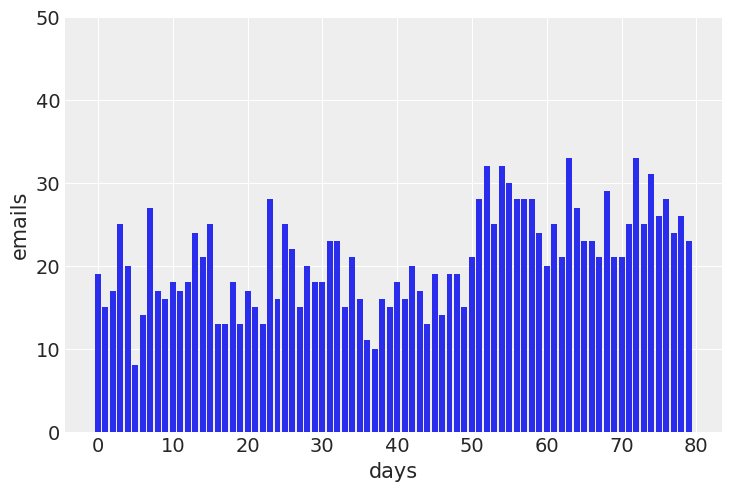

In [7]:
plt.bar(idx, count)
plt.xlabel("days")
plt.ylabel("emails")
plt.ylim([0,50])

In [8]:
with pm.Model() as model:
    alpha = 1./count.mean()
    lambda1 = pm.Exponential("lambda1", alpha)
    lambda2 = pm.Exponential("lambda2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=Ndays-1)
    
    lambda_ = pm.math.switch(tau > idx, lambda1, lambda2)
    likelihood = pm.Poisson("likelihood",lambda_, observed=count)
    
    

In [9]:
with model:
    trace = pm.sample()
    
    

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lambda1, lambda2]
>Metropolis: [tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


array([[<Axes: title={'center': 'tau'}>, <Axes: title={'center': 'tau'}>],
       [<Axes: title={'center': 'lambda1'}>,
        <Axes: title={'center': 'lambda1'}>],
       [<Axes: title={'center': 'lambda2'}>,
        <Axes: title={'center': 'lambda2'}>]], dtype=object)

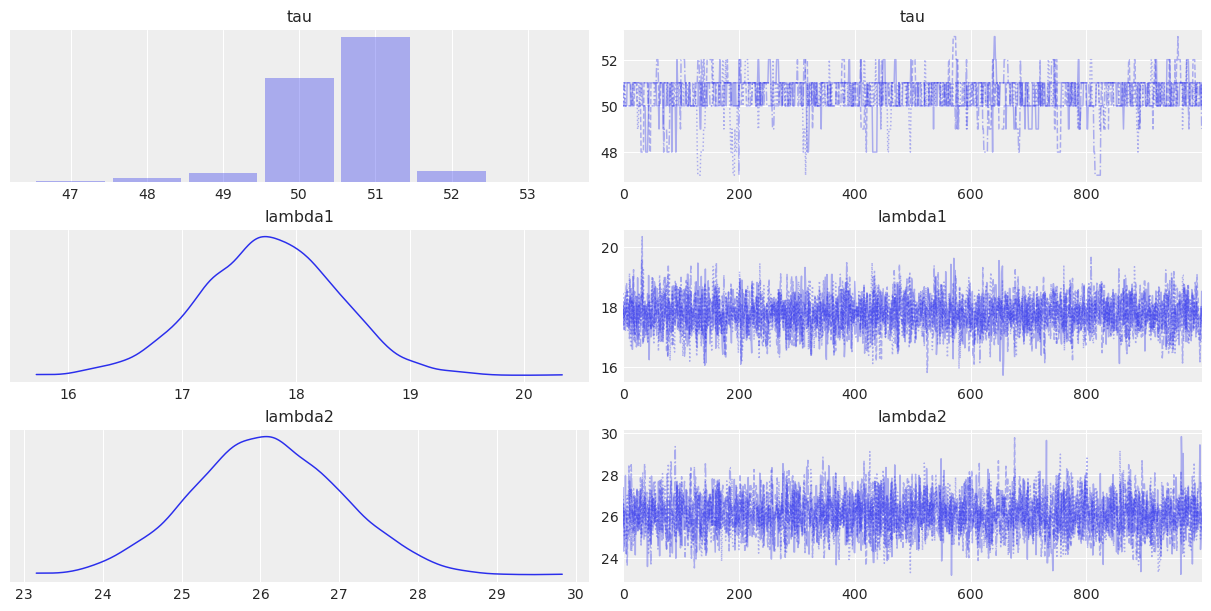

In [10]:
az.plot_trace(trace, combined=True)



In [11]:
# expected value of messagge each day?


In [12]:
tau_samples = trace.posterior["tau"].stack(samples=("chain","draw"))
lambda1_samples = trace.posterior["lambda1"].stack(samples=("chain","draw"))
lambda2_samples = trace.posterior["lambda2"].stack(samples=("chain","draw"))

In [13]:
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(Ndays)
for day in range(0, Ndays):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda1_samples[ix].sum()
                                   + lambda2_samples[~ix].sum()) / N

(0.0, 50.0)

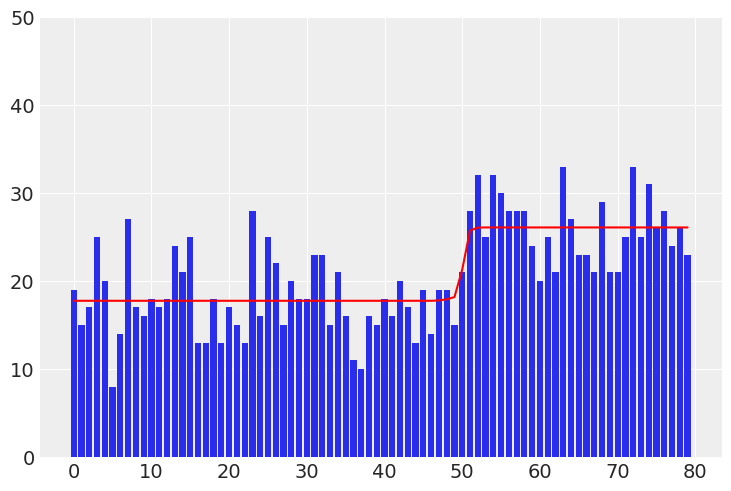

In [14]:
plt.bar(idx, count)
plt.plot(idx, expected_texts_per_day, c='red')
plt.ylim([0,50])